# Prédiction des arrivées aux urgences

## Initialisation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import statistics
import xgboost as xgb

from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
type_target = 'arrivees_urgences'
assert type_target in ['hospitalisations', 'arrivees_urgences']
horizon = 15
NUM_FEATS = 50
DEPARTEMENT = 'Dijon'

In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18,8)

def teste(df, params, score=100000, ma=7, verbose=False):
    MAEs, MSEs = [], []
    new_score = 100000
    reg_best = None
    final = df.loc[df.index.year==2023]
    X_final = final.drop('target', axis=1)
    y_final = final['target']

    for max_depth in [5]:
        params['max_depth'] = max_depth
        train_val_test = df.copy()
        for annee in range(2019, 2024):
            train_val = train_val_test.loc[train_val_test.index.year != annee]
            test = train_val_test.loc[train_val_test.index.year == annee]
            X_test = test.drop('target', axis=1)
            y_test = test['target']
            X_train, X_valid, y_train, y_valid = train_test_split(train_val.drop('target', axis=1), train_val['target'], 
                                                                  test_size=0.2, shuffle=False)
                    
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dvalid = xgb.DMatrix(X_valid, label=y_valid)
            dtest = xgb.DMatrix(X_test, label=y_test)
            evals = [(dtrain, 'train'), (dvalid, 'eval')]
            bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                            early_stopping_rounds=15, verbose_eval=verbose)
        
            y_pred = bst.predict(dtest)
            MAEs.append(mean_absolute_error(y_test, y_pred))
            MSEs.append(mean_squared_error(y_test, y_pred))

        current_score = statistics.mean(MSEs)
        if current_score < new_score:
            train_val_test = df.loc[df.index.year<2023]
            previous_score = new_score
            new_score = current_score
            if new_score < score:
                print(f"Amélioration avec {max_depth=}: {min(previous_score, score):.4f} -> {new_score:.4f}")
                new_score = statistics.mean(MSEs)
                X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                                    train_val_test['target'], 
                                                                    test_size=0.2, shuffle=False)

                dtrain = xgb.DMatrix(X_train, label=y_train)
                dvalid = xgb.DMatrix(X_valid, label=y_valid)
                dtest = xgb.DMatrix(X_final, label=y_final)
                evals = [(dtrain, 'train'), (dvalid, 'eval')]
                bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                                early_stopping_rounds=15, verbose_eval=verbose)
                reg_best = bst
                y_pred = bst.predict(dtest)
                #y_pred_ma = pd.Series(y_pred).rolling(window=ma, center=True).mean()
                N = 365
                plt.figure()
                plt.plot(range(len(y_final))[-N:], y_final[-N:], label='actual', color='blue')
                plt.plot(range(len(y_pred))[-N:], y_pred[-N:], label='predict', color='orange')
                #plt.plot(range(len(y_pred))[-N:], y_pred_ma[-N:], label='trend', color='red')
                plt.legend()
                '''y_test_ma = y_final.rolling(window=ma, center=True).mean()
                
                plt.figure()
                plt.plot(range(len(y_final)), y_test_ma, label='actual')
                plt.plot(range(len(y_pred)), y_pred_ma, label='predict')
                plt.legend()
                '''
                display(plt.gcf())

                mean_y_test = np.mean(y_final)
                error_percentage = np.abs((y_pred - y_final) / mean_y_test) * 100
                percent_below_thresholds = {}
                for threshold in range(1, 12):  # de 1% à 30%
                    percent_below = np.mean(error_percentage < threshold) * 100
                    percent_below_thresholds[threshold] = percent_below
                for threshold, percent_below in percent_below_thresholds.items():
                    print(f"{percent_below:.2f}%,{threshold}%")

                print(f"   - MAE : {statistics.mean(MAEs):.2f} ({mean_absolute_error(y_pred, y_final):.2f} sur 2023)")
                print(f"   - MSE : {statistics.mean(MSEs):.2f} ({mean_squared_error(y_pred, y_final):.2f} sur 2023)")
    return new_score, reg_best

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
assert type_target in ['hospitalisations', 'arrivees_urgences']
if type_target == 'hospitalisations':
    df = pd.read_csv('RPU_vers_hospit_adultes.csv', sep=';')
    df['date_entree'] = pd.to_datetime(df['date_entree'], format="%d/%m/%Y")
    df.rename({'Total': type_target}, axis=1, inplace=True)
    df['target'] = df[type_target].copy()
    # on ajoute les arrivées aux urgences, que l'on suppose connues pour le jour J
    dff = pd.read_feather('CHU Dijon_volumes.feather')
    dff.rename({'Total': 'arrivees_urgences'}, axis=1, inplace=True)
    dff.reset_index(inplace=True)
    df = pd.merge(df, dff, on='date_entree')
else:
    df = pd.read_feather('CHU Dijon_volumes.feather')
    df.rename({'Total': type_target}, axis=1, inplace=True)
    df['target'] = df[type_target].copy()

In [5]:
# On ajoute la target
if type_target == 'hospitalisations':
    horizon = 7
else:
    horizon = 3
df['mean'] = df[type_target].rolling(window=horizon, min_periods=1).mean()
df['target'] = df['mean'].shift(-2*horizon+1)
df.drop('mean', axis=1, inplace=True)

df.dropna(inplace=True)
df.shape

(1821, 2)

<Axes: xlabel='date_entree'>

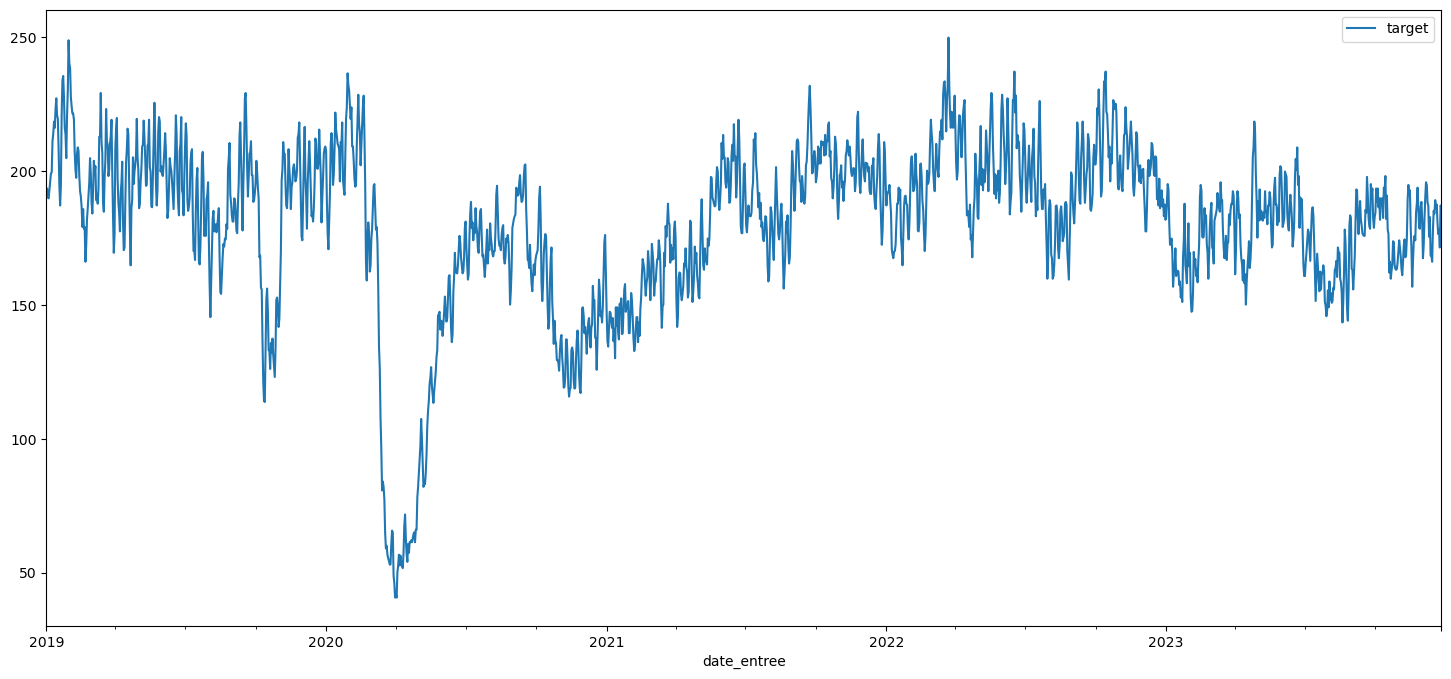

In [6]:
df.plot(y='target')

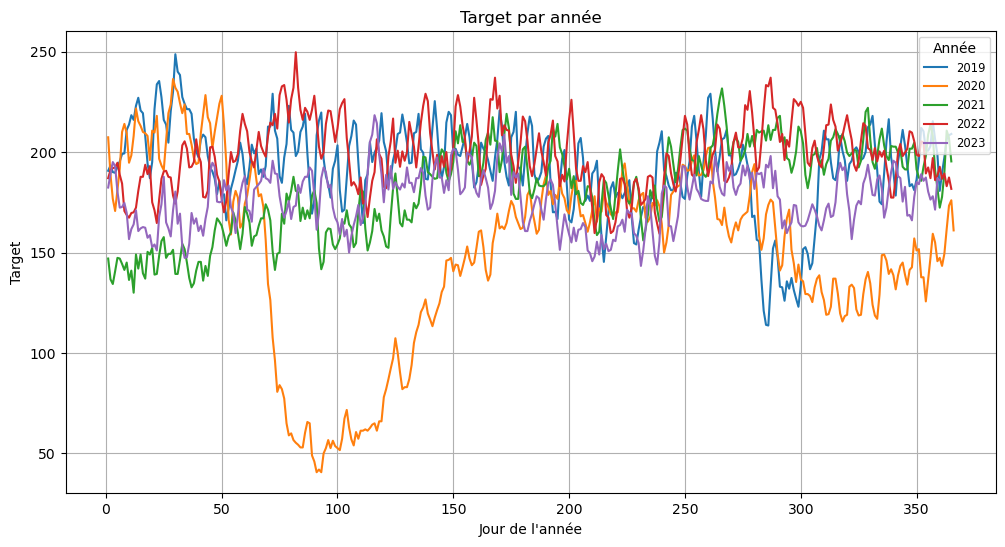

In [7]:
df['Année'] = df.index.year

plt.figure(figsize=(12, 6))
for year, group in df.groupby('Année'):
    plt.plot(group.index.dayofyear, group['target'], label=str(year))

plt.xlabel("Jour de l'année")
plt.ylabel("Target")
plt.title("Target par année")
plt.legend(title="Année", loc='upper right', fontsize='small')
plt.grid(True)
plt.show()


In [8]:
for k in range(2*horizon-1, 15):
    df[f'target_history-{k}'] = df['target'].shift(k)

In [9]:
for k in range(1, 15):
    df[f'{type_target}_history-{k}'] = df[type_target].shift(k)

In [10]:
dg = pd.read_csv('features_all_origin.csv', sep=',')
dg.drop('Total', axis=1, inplace=True)
dg['date_entree'] = pd.to_datetime(dg['date_entree'], format="%Y-%m-%d")
df = pd.merge(df, dg, on='date_entree', how='left')
df.set_index('date_entree', inplace=True)
df.dropna(inplace=True)

In [11]:
print(f"Moyenne : {df['target'].mean():.2f}, Ecart-type : {df['target'].std():.2f}")
print(f"Baseline : {mean_absolute_error(df['target'], [df['target'].mean()]*len(df)):.2f}")

Moyenne : 179.62, Ecart-type : 31.61
Baseline : 22.69


In [12]:
df['HNFC_moving'] = df['HNFC_moving']=='Après'
df.drop('nom_etablissement', axis=1, inplace=True)
df = df.drop(df.loc['2020-03':'2020-05'].index)

In [13]:
shifted = df["target"].shift(2*horizon-1)
for ma in [2, 3, 7, 15, 30]:    
    window = shifted.rolling(window=ma)
    df[f'target_ma_{ma}'] = window.mean()
    df.bfill(inplace=True)

shifted = df[type_target].shift(1)
for ma in [2, 3, 7, 15, 30]:    
    window = shifted.rolling(window=ma)
    df[f'{type_target}_ma_{ma}'] = window.mean()
    df.bfill(inplace=True)


In [14]:
# On sauvegarde notre dataframe
df0 = df.copy()

In [15]:
params = {'eta': 0.05, 
          'objective': 'reg:absoluteerror', 
          'eval_metric': ['rmse', 'mae'],
          'subsample': 0.7, 
          'colsample_bytree': 1,
          'nthread': -1}

horizon: 1
horizon: 2
horizon: 3
horizon: 4
horizon: 5
horizon: 6
horizon: 1
horizon: 2
horizon: 3
horizon: 4
horizon: 5
horizon: 6


<Axes: xlabel='date_entree'>

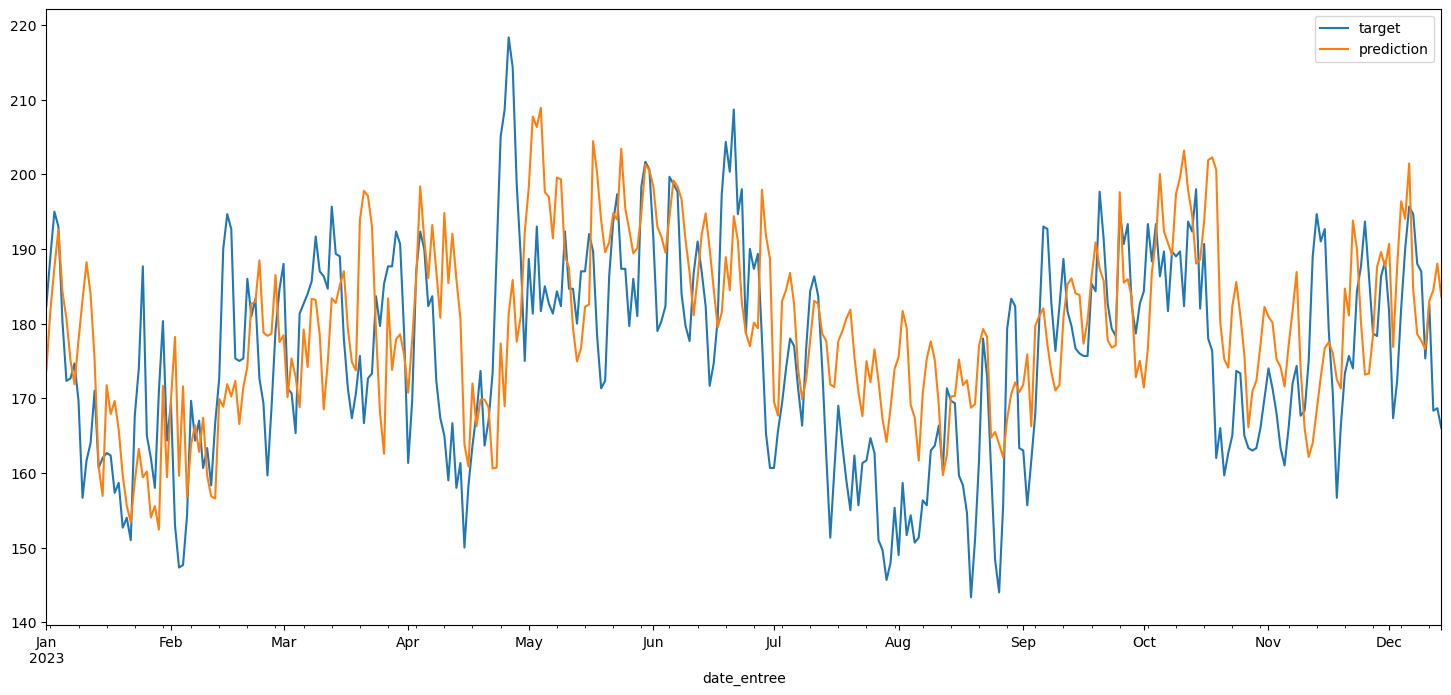

In [34]:
regs = {'trend': {}, 'resid': {}, 'seasonal': {}}
cols = ['arrivees_urgences', 'air_PM10_FR26014_mean', 'trend_grippe_std', 'trend_maladie_mean', 'holidays', 
        'meteo_night_CHU DIJON_0_temp_mean', 'target_ma_7']
for k in range(1, 2*horizon+1):
    print(f"horizon: {k}")
    dg = df[cols].copy()
    dg['target'] = dg['arrivees_urgences'].shift(-k)
    dg.dropna(inplace=True)
    regs['seasonal'][k] = seasonal_decompose(dg['target'], model='additive', period=7).seasonal
    dg['target'] = seasonal_decompose(dg['target'], model='additive', period=7).trend
    dg.dropna(inplace=True)
    train_val_test = dg.loc[dg.index.year < 2023]
    d_final = dg.loc[dg.index.year == 2023]
    X_final = d_final.drop('target', axis=1)
    y_final = d_final['target']
    X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                        train_val_test['target'], 
                                                        test_size=0.2, shuffle=False)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(dtrain, 'train'), (dvalid, 'eval')]
    regs['trend'][k] = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                        early_stopping_rounds=15, verbose_eval=False)
    y_pred = regs['trend'][k].predict(xgb.DMatrix(X_final))
    dg[f'target'] = seasonal_decompose(dg['target'], model='additive', period=7).resid
    dg.dropna(inplace=True)
    train_val_test = dg.loc[dg.index.year < 2023]
    d_final = dg.loc[dg.index.year == 2023]
    X_final = d_final.drop('target', axis=1)
    y_final = d_final['target']
    X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                        train_val_test['target'], 
                                                        test_size=0.2, shuffle=False)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(dtrain, 'train'), (dvalid, 'eval')]
    regs['resid'][k] = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                        early_stopping_rounds=15, verbose_eval=False)
    y_pred = regs['resid'][k].predict(xgb.DMatrix(X_final))
    df[f'{type_target}+{k}'] = dg.target.copy()

dg = df.copy()
for k in range(1, 2*horizon+1):
    print(f"horizon: {k}")
    X_final[f'{type_target}+{k}'] = regs['trend'][k].predict(xgb.DMatrix(X_final[regs['trend'][k].feature_names]))
    X_final[f'{type_target}+{k}'] += regs['resid'][k].predict(xgb.DMatrix(X_final[regs['resid'][k].feature_names]))
    X_final[f'{type_target}+{k}'] += regs['seasonal'][k]


X_final['prediction'] = X_final.apply(lambda x: statistics.mean([x[f'{type_target}+{k}'] for k in range(horizon, 2*horizon)]), axis=1)

X_final['target'] = df.loc[df.index.year == 2023]['target']
X_final.plot(y=['target', 'prediction'])


horizon: 1
horizon: 2
horizon: 3
horizon: 4
horizon: 5
horizon: 6


<Axes: xlabel='date_entree'>

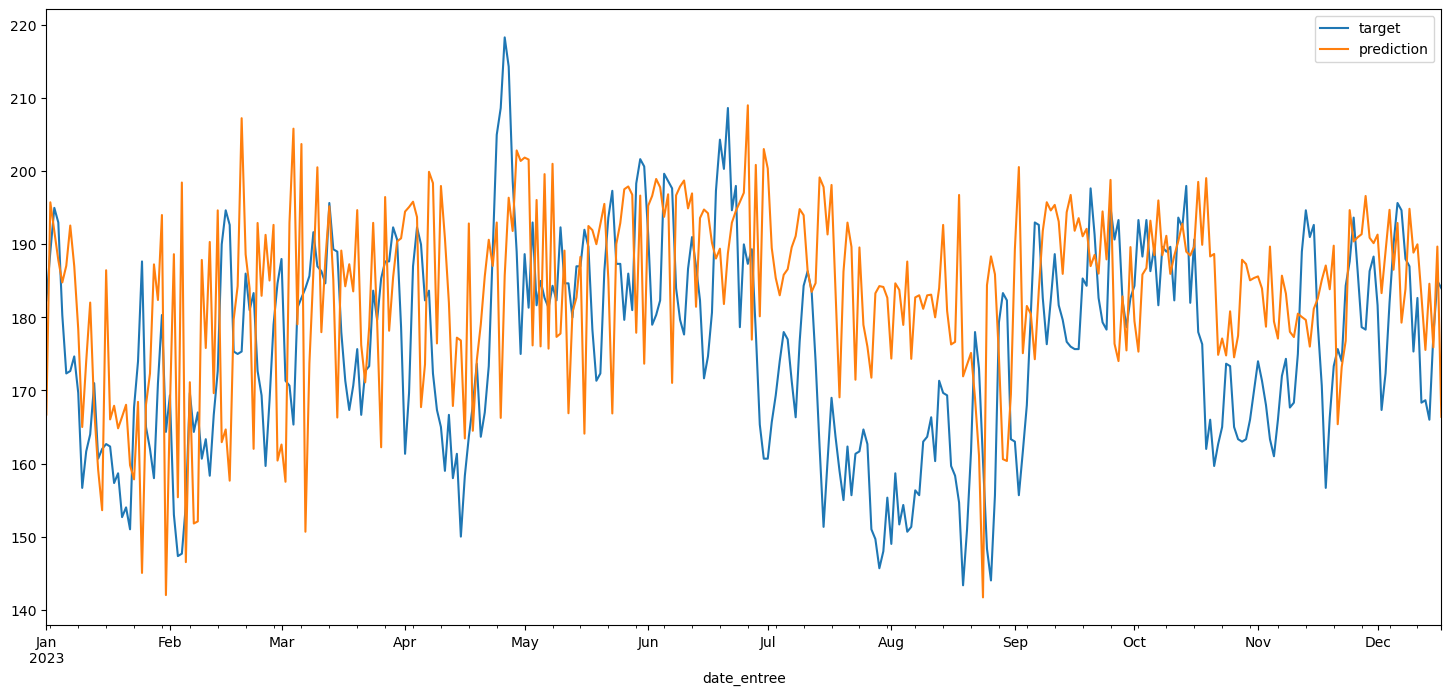

In [23]:
X_final['target'] = df.loc[df.index.year == 2023]['target']
X_final.plot(y=['target', 'prediction'])

## On va commencer par prédire la tendance

### Calendaire

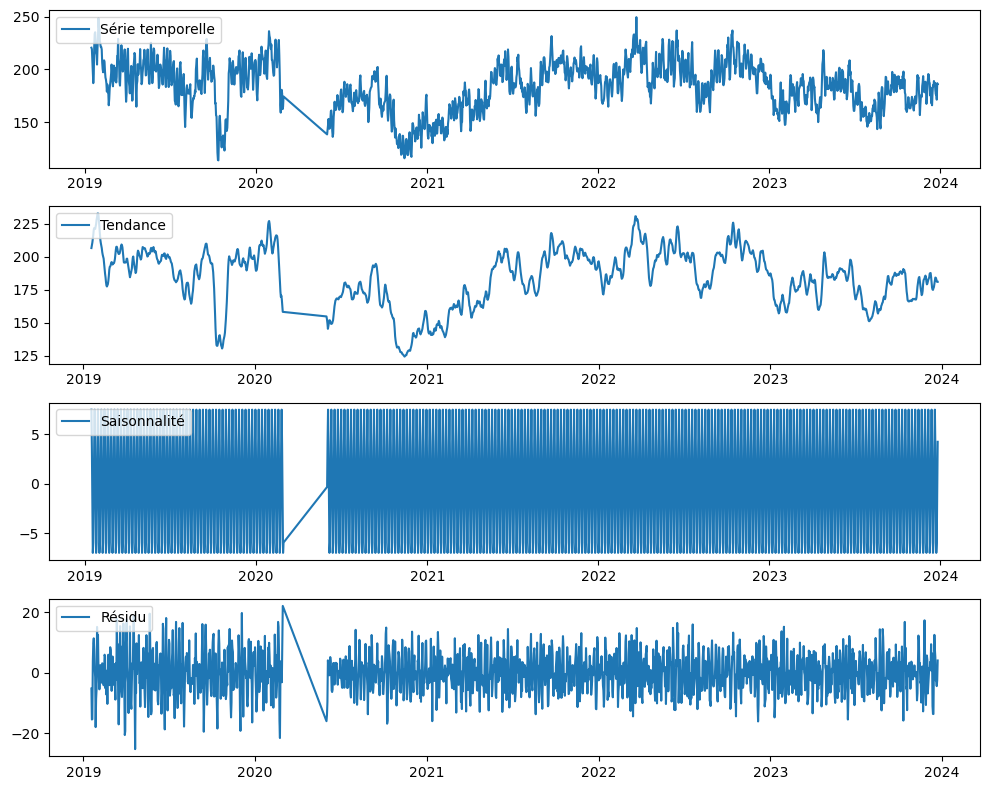

In [15]:
y = df['target']
result = seasonal_decompose(y, model='additive', period=7)

# Affichage des composantes
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(y, label='Série temporelle')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Tendance')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Saisonnalité')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Résidu')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [16]:
df = df0.copy()
df['target'] = result.trend.copy()
df.dropna(inplace=True)

Amélioration avec max_depth=3: 100000.0000 -> 179.5674


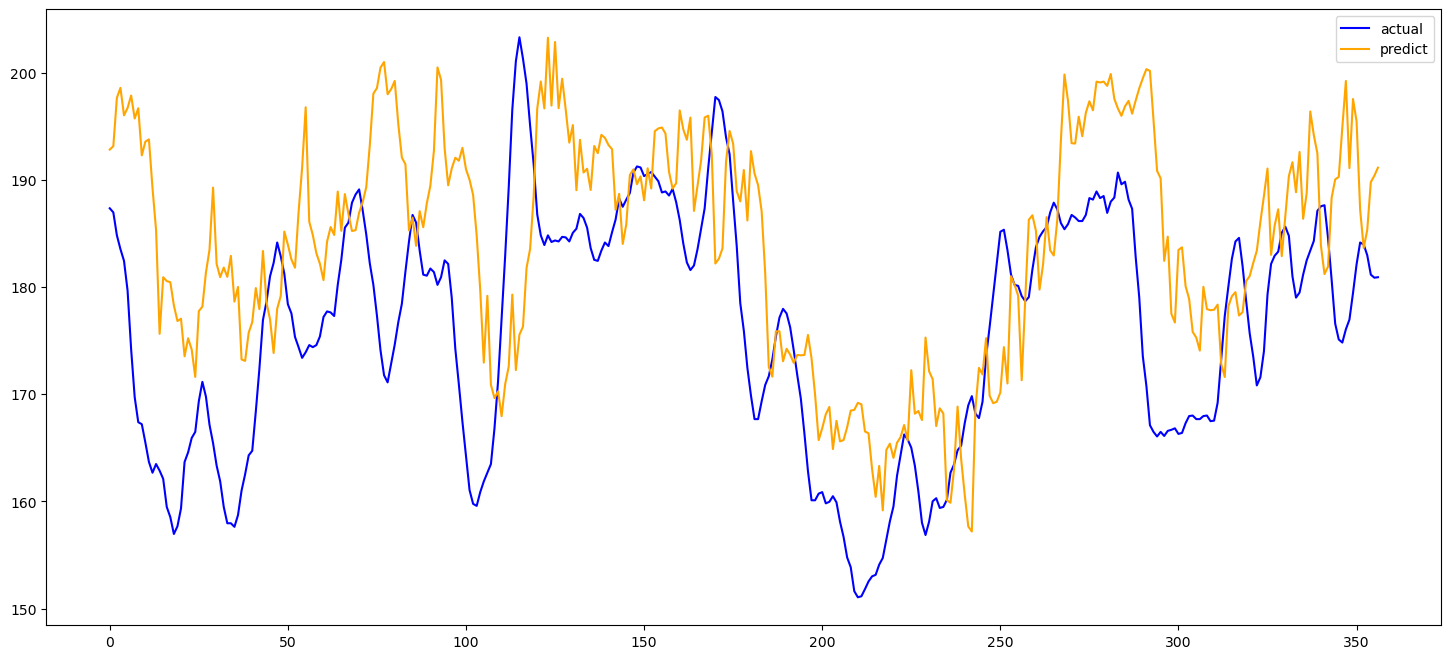

10.92%,1%
19.89%,2%
29.13%,3%
38.94%,4%
48.18%,5%
58.82%,6%
68.07%,7%
74.51%,8%
78.99%,9%
81.79%,10%
87.11%,11%
   - MAE : 10.31 (10.30 sur 2023)
   - MSE : 179.57 (161.41 sur 2023)
                              feature        gain       cover  weight  \
0                         target_ma_7  137.453506  630.375000    16.0   
1                   target_history-10  154.579361  751.000000     1.0   
2                         target_ma_2  132.433899  687.750000     8.0   
3                        target_ma_15  115.615479  559.222229     9.0   
4                    target_history-5   81.395706  516.190491    21.0   
5                   arrivees_urgences   46.363373  560.357117    28.0   
6                total_CHU Dijon_mean   62.370407  634.842102    19.0   
7                    trend_grippe_std   21.474800  672.111084    18.0   
8               air_PM10_FR26014_mean   16.807796  506.571442    21.0   
9                            holidays   39.119026  406.750000    12.0   
10             

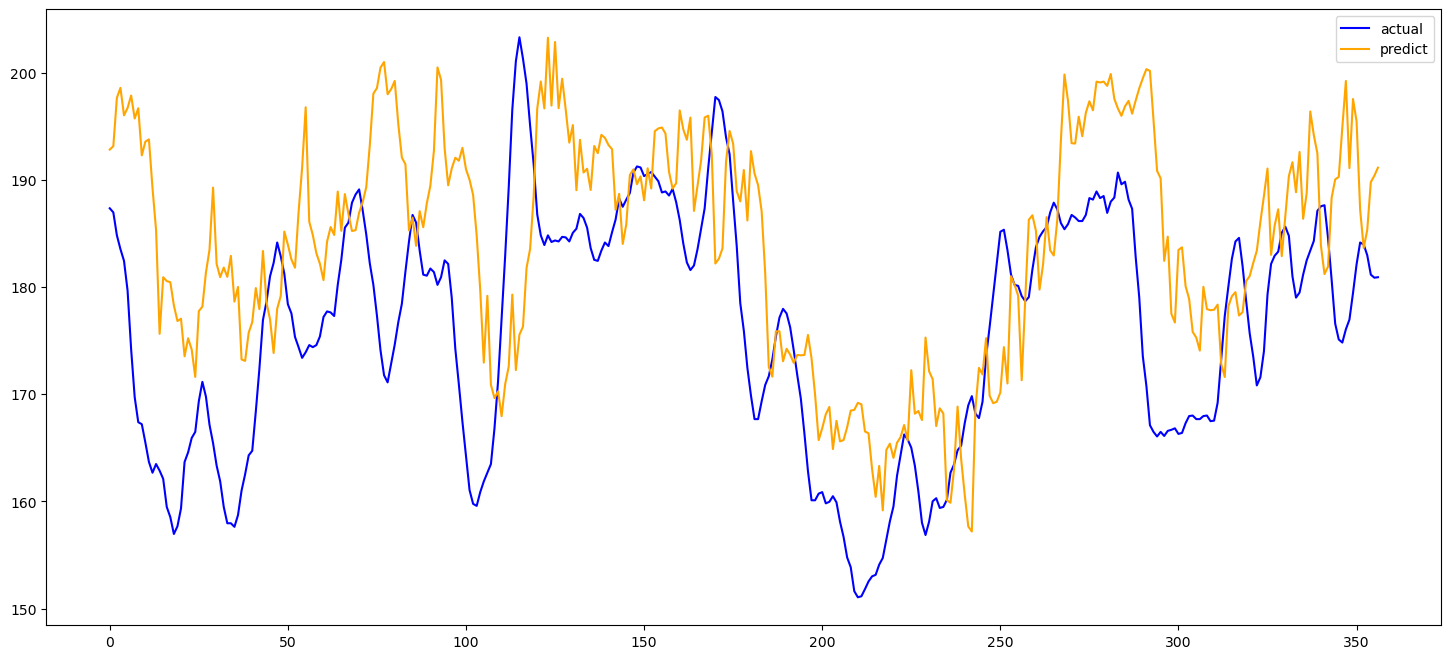

In [17]:
params = {'eta': 0.05, 
          'objective': 'reg:absoluteerror', 
          'eval_metric': ['rmse', 'mae'],
          'subsample': 0.7, 
          'colsample_bytree': 1,
          'nthread': -1}

new_score, bst = teste(df, params)

# Un exemple pour déterminer l'importance des variables après un pré-apprentissage XGBoost
importance_gain = bst.get_score(importance_type='gain')
importance_cover = bst.get_score(importance_type='cover')
importance_weight = bst.get_score(importance_type='weight')

df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df['gain_norm'] = df['gain'] / df['gain'].sum()
df['cover_norm'] = df['cover'] / df['cover'].sum()
df['weight_norm'] = df['weight'] / df['weight'].sum()

w_gain = 0.5
w_cover = 0.3
w_weight = 0.2

df['importance'] = (df['gain_norm'] * w_gain) + (df['cover_norm'] * w_cover) + (df['weight_norm'] * w_weight)

df.sort_values(by='importance', ascending=False, inplace=True)
df['rank'] = df['importance'].rank(ascending=False)

df.reset_index(inplace=True)
df.rename(columns={'index': 'feature'}, inplace=True)
print(df[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']].head(20))


Amélioration avec max_depth=3: 100000.0000 -> 223.8714


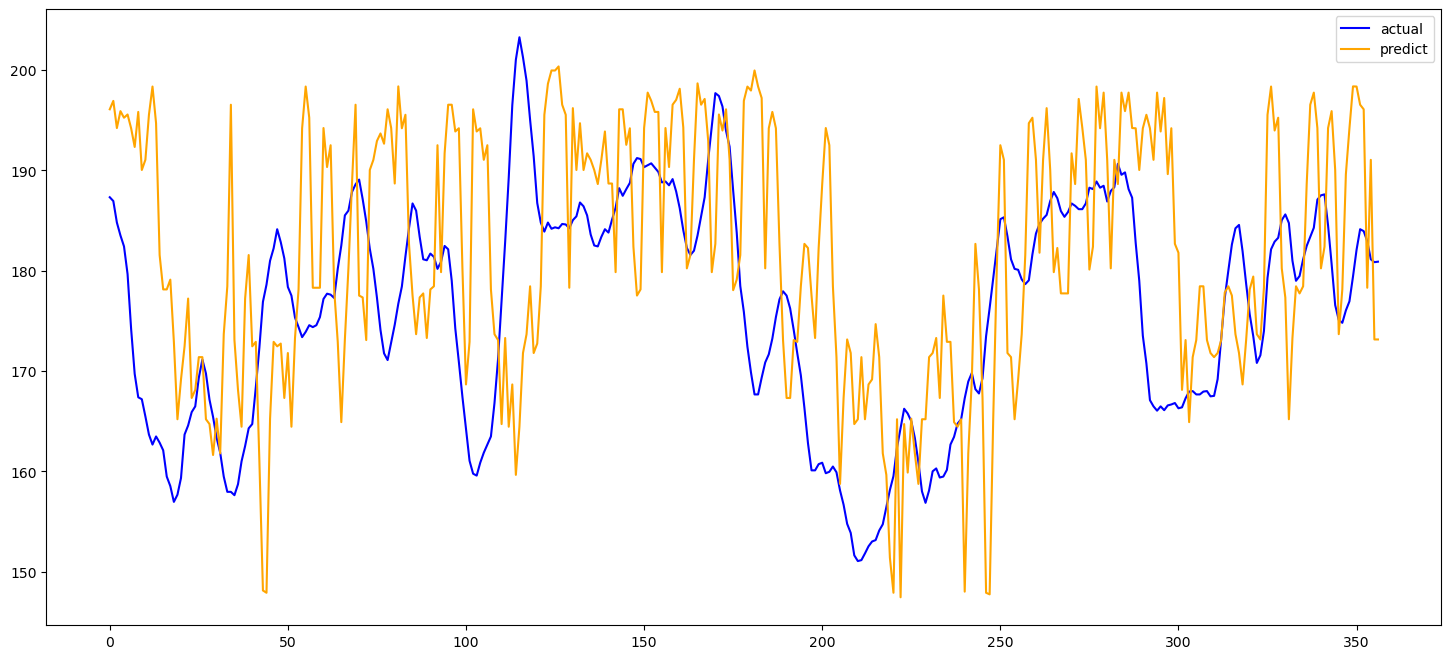

7.84%,1%
17.37%,2%
25.21%,3%
33.33%,4%
43.98%,5%
52.66%,6%
60.22%,7%
68.63%,8%
74.51%,9%
79.83%,10%
82.63%,11%
   - MAE : 11.68 (11.68 sur 2023)
   - MSE : 223.87 (209.44 sur 2023)


(223.87138560322845, <xgboost.core.Booster at 0x778d741e7020>)

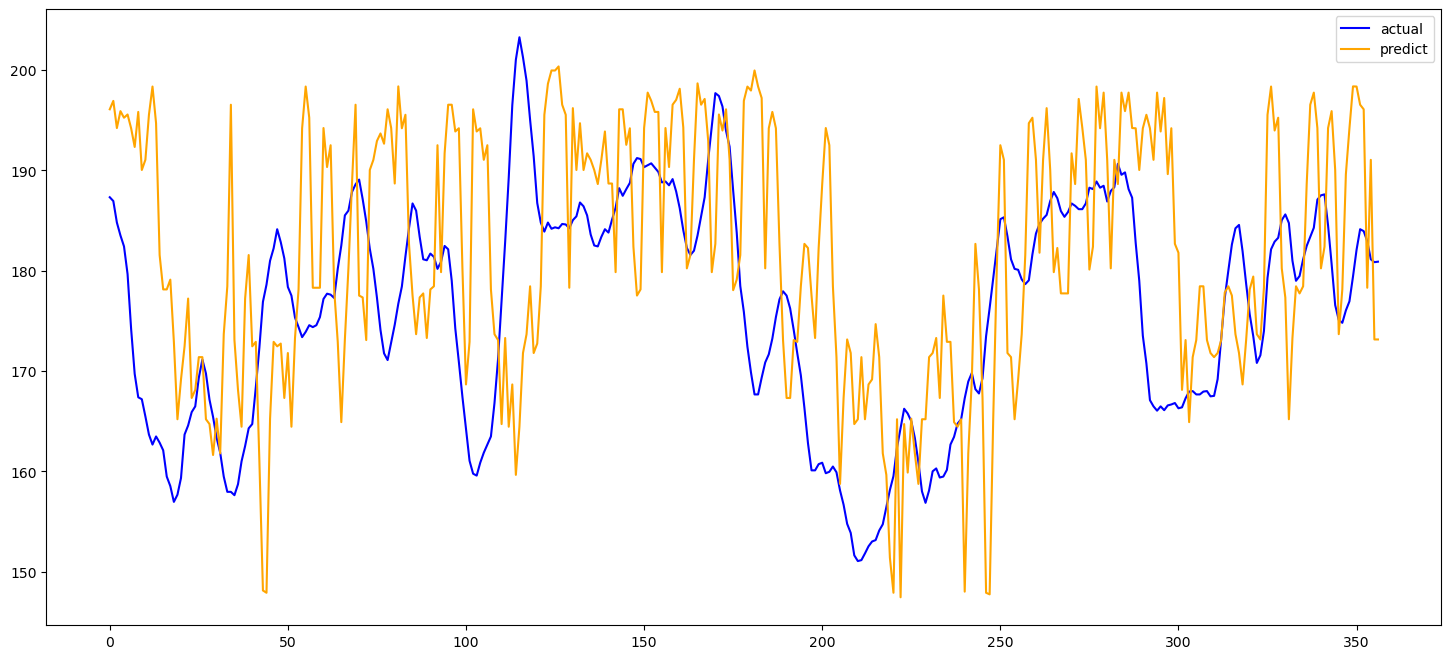

In [19]:
df = df0.copy()
df['target'] = result.trend.copy()
df.dropna(inplace=True)

teste(df[['arrivees_urgences', 'target']], params)

In [42]:
assert False

AssertionError: 

Amélioration avec max_depth=3: 100000.0000 -> 618.0384


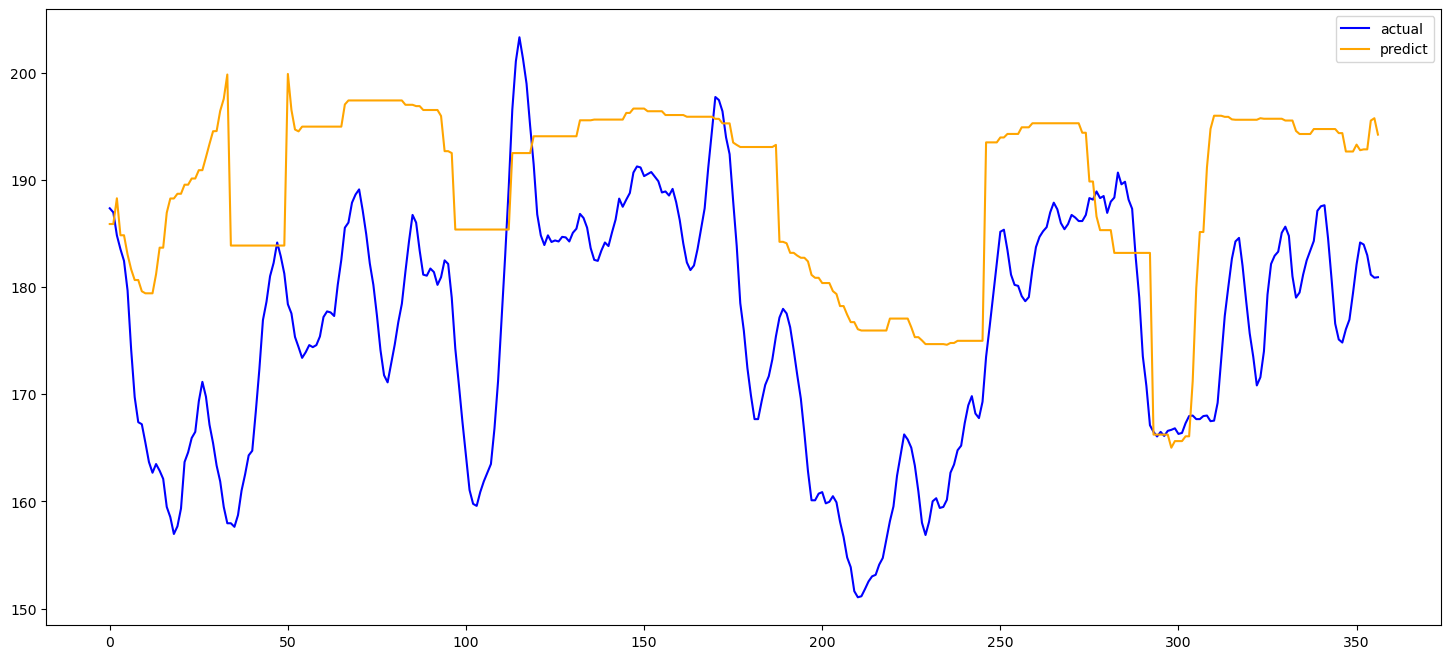

6.72%,1%
11.20%,2%
13.73%,3%
19.33%,4%
29.13%,5%
39.50%,6%
48.18%,7%
56.02%,8%
64.71%,9%
70.03%,10%
74.51%,11%
   - MAE : 18.86 (13.52 sur 2023)
   - MSE : 618.04 (240.79 sur 2023)


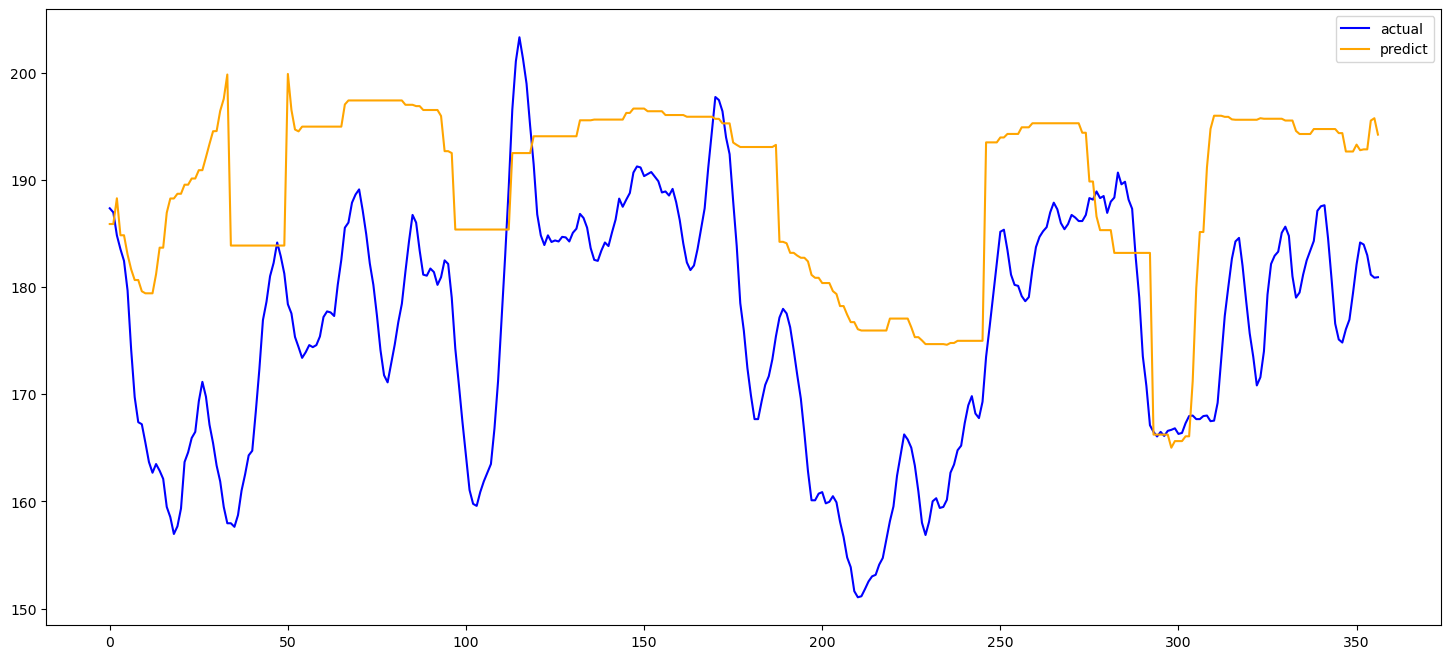

In [15]:
params = {'eta': 0.05, 
          'objective': 'reg:absoluteerror', 
          'eval_metric': ['rmse', 'mae'],
          'subsample': 0.7, 
          'colsample_bytree': 1,
          'nthread': -1}

score = 100000
cols = ['dayofYear', 'month']
col = "holidays"
new_score, _ = teste(df[cols+[col, 'target']], params, score=score)

### Historique

In [16]:
params = {'eta': 0.05, 
		  'objective': 'reg:squarederror',
          'eval_metric': ['rmse', 'mae'], 
          # seule la rmse sera utilisée pour valider
          'subsample': 0.7, 'colsample_bytree': 0.7,
          'nthread': -1}

Amélioration avec max_depth=3: 100000.0000 -> 343.3382


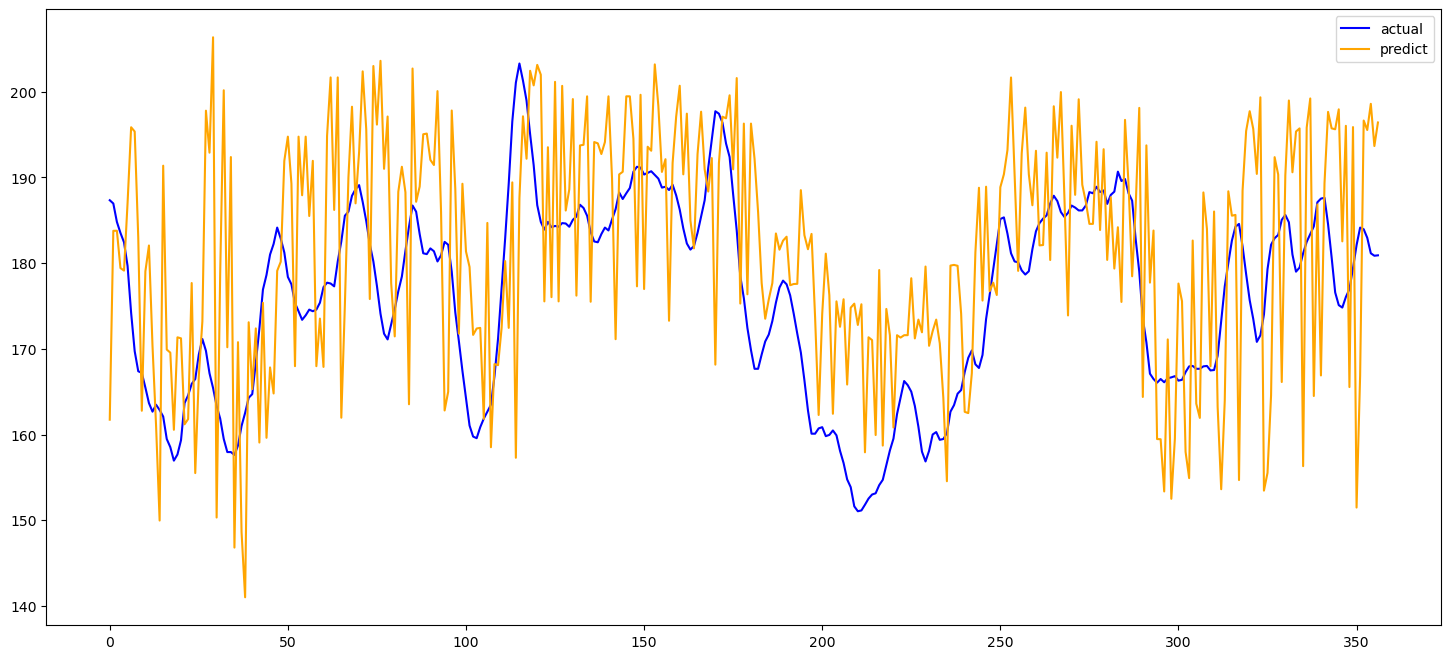

7.00%,1%
16.53%,2%
26.89%,3%
35.01%,4%
40.90%,5%
48.74%,6%
56.58%,7%
66.11%,8%
72.27%,9%
79.55%,10%
84.59%,11%
   - MAE : 14.49 (11.50 sur 2023)
   - MSE : 343.34 (191.62 sur 2023)
MAE: 14.00


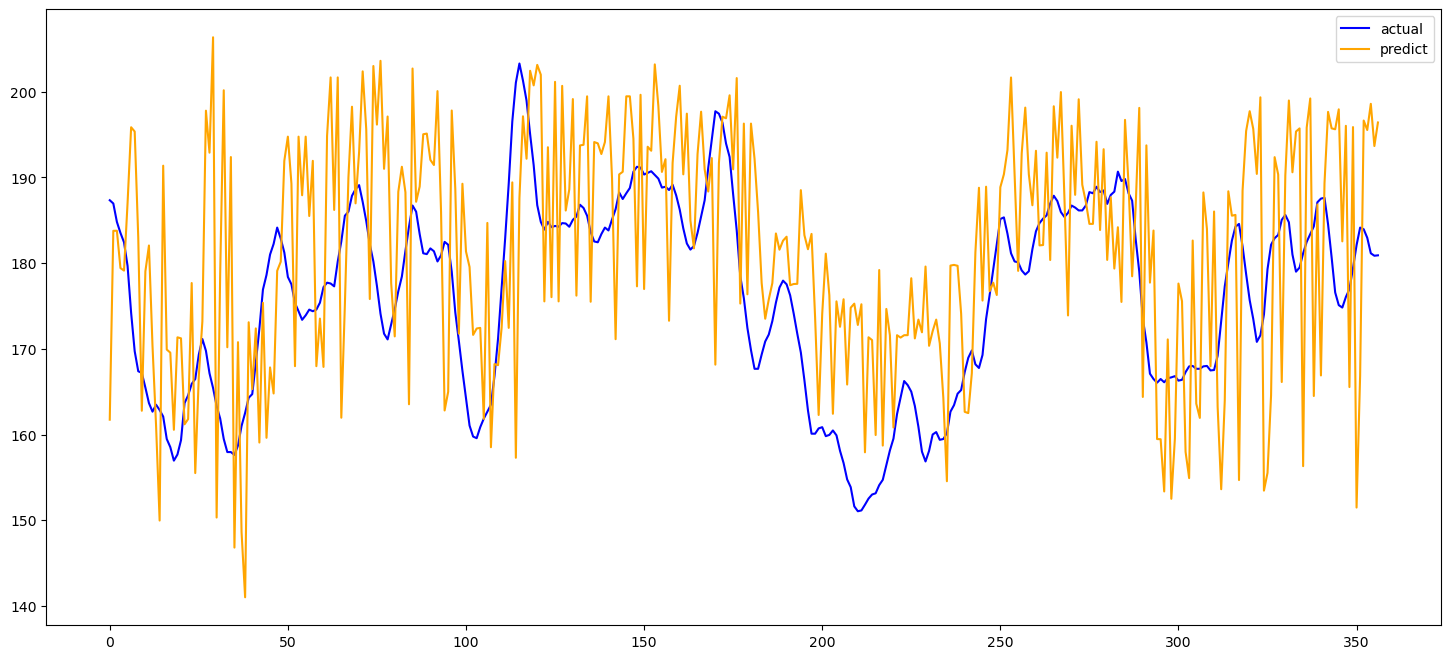

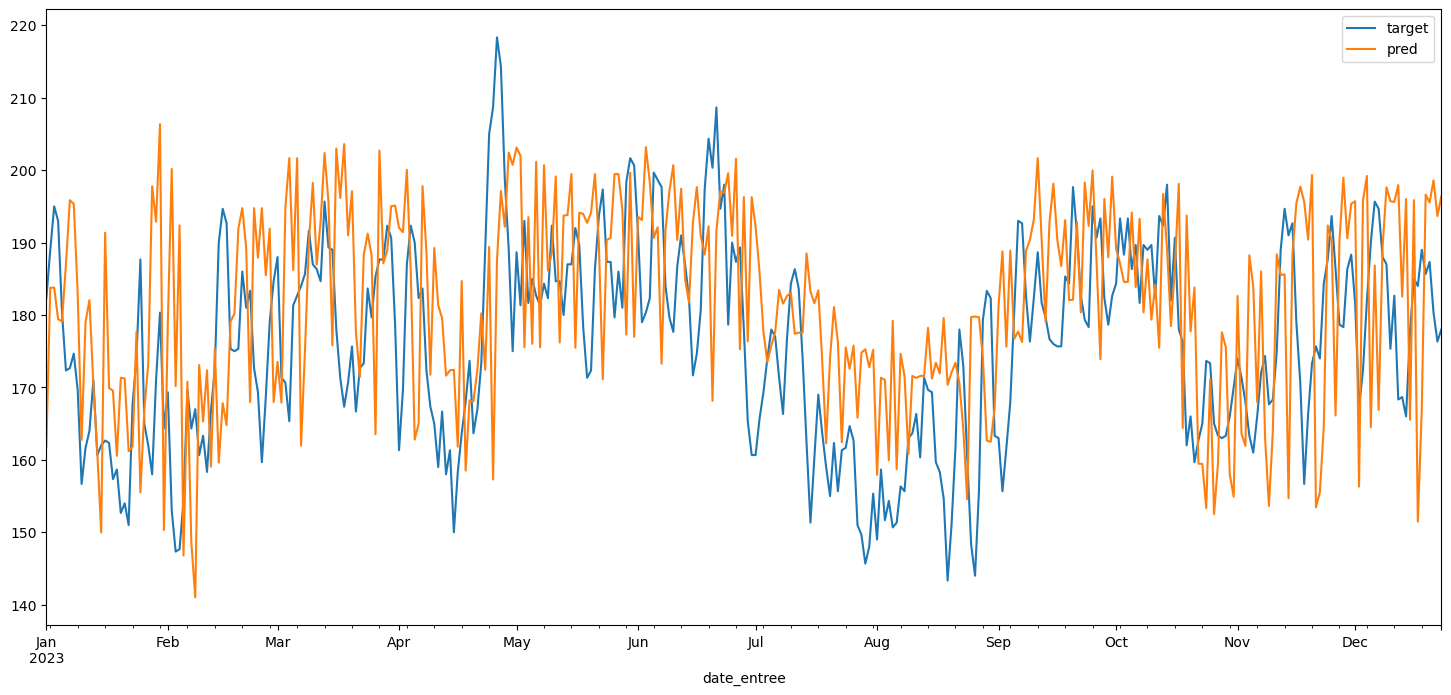

In [17]:
cols = ['dayofYear', 'month', 'holidays', 'arrivees_urgences']
score, reg = teste(df[cols+['target']], params)

dg = df0.loc[df0.index.year == 2023][:-3]
dg['pred'] = reg.predict(xgb.DMatrix(df.loc[df.index.year == 2023][cols]))
dg.plot(y=['target', 'pred'])
print(f"MAE: {mean_absolute_error(dg['target'], dg['pred']):.2f}")


Amélioration avec max_depth=3: 100000.0000 -> 271.6147


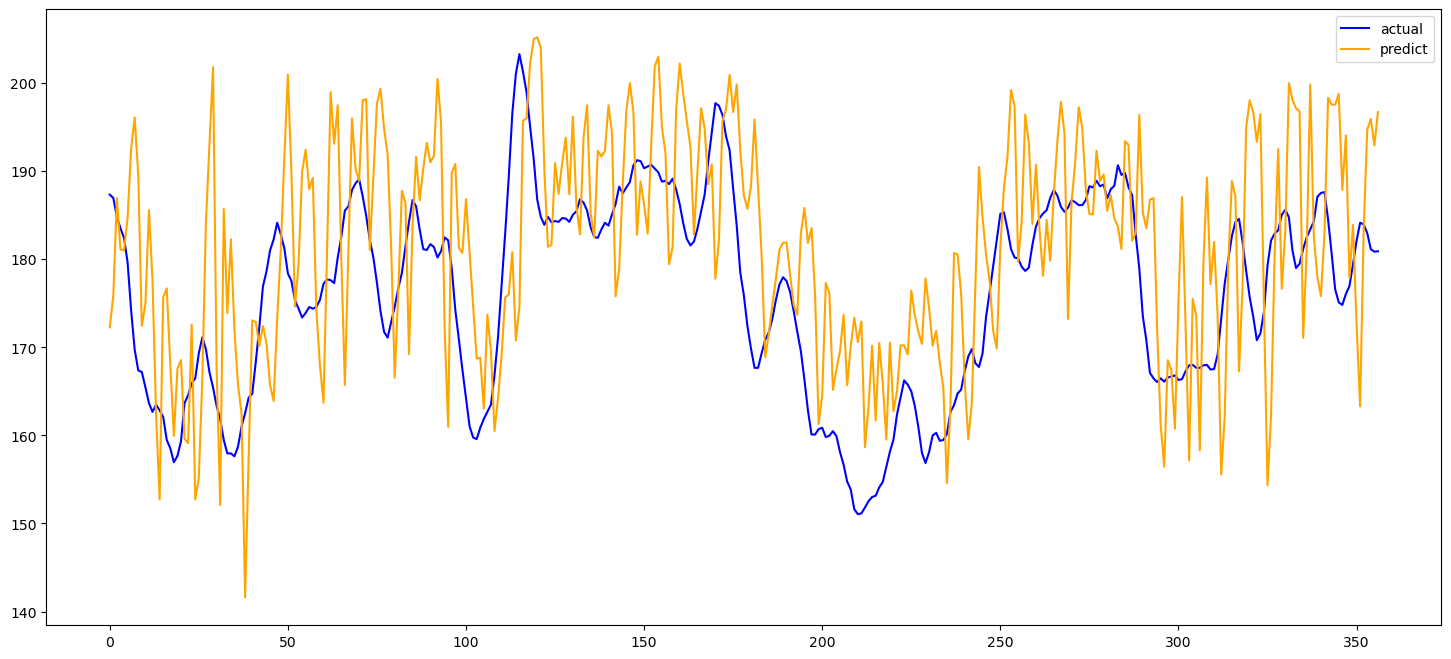

11.48%,1%
21.57%,2%
30.53%,3%
38.10%,4%
47.06%,5%
56.86%,6%
65.55%,7%
71.43%,8%
77.87%,9%
84.31%,10%
87.68%,11%
   - MAE : 12.46 (10.14 sur 2023)
   - MSE : 271.61 (151.42 sur 2023)
MAE: 12.51


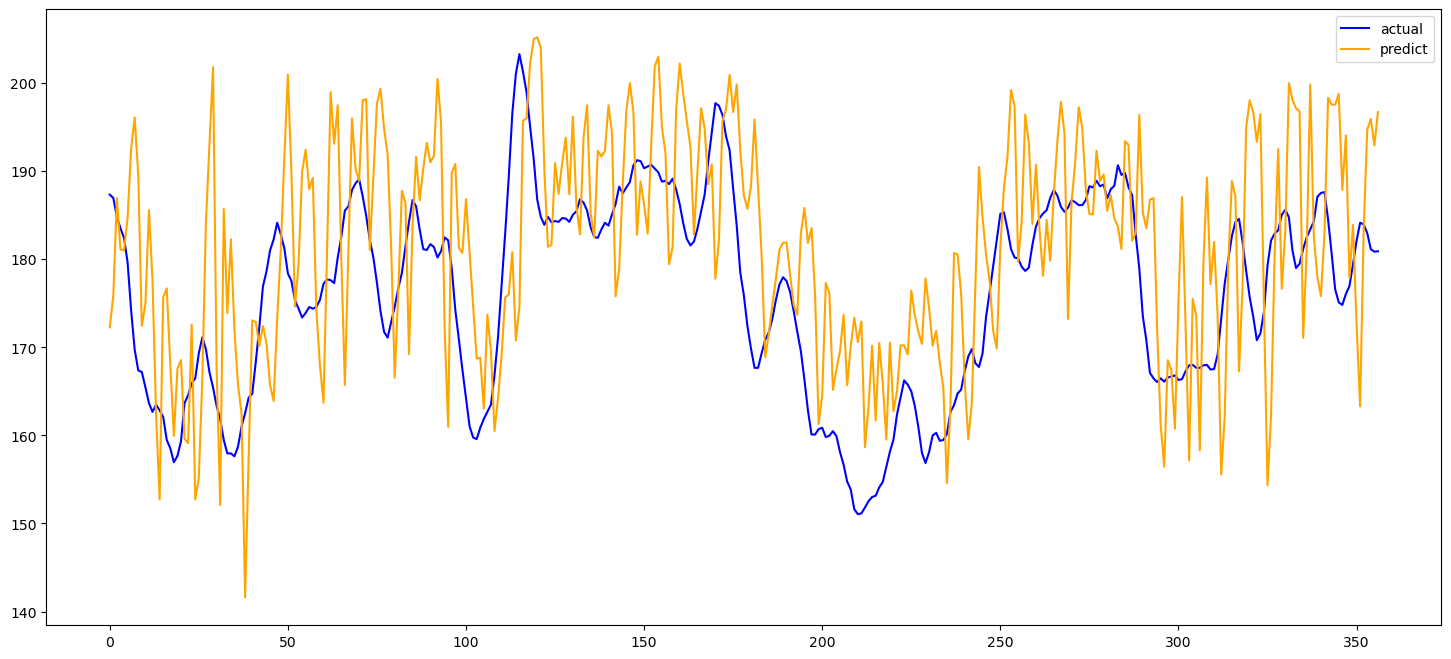

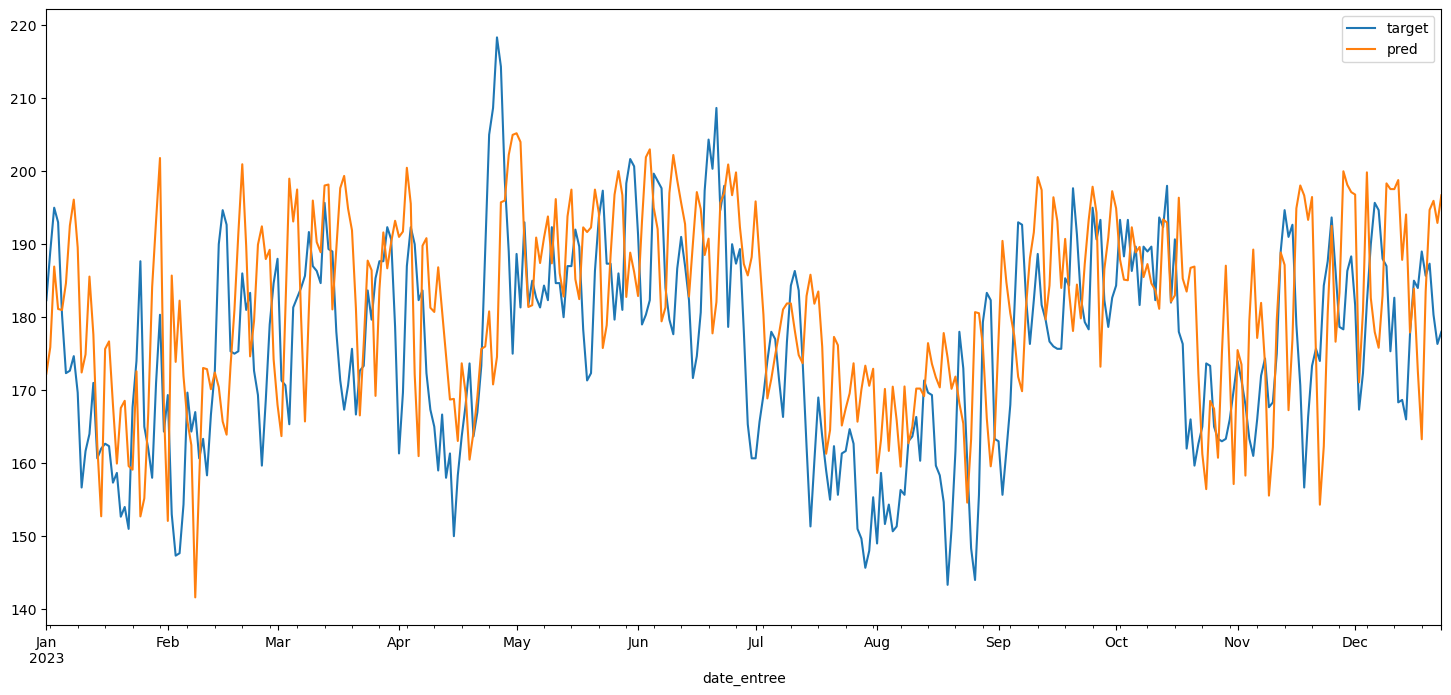

In [18]:
cols = ['dayofYear', 'month', 'holidays', 'arrivees_urgences', 'arrivees_urgences_history-1']
score, reg = teste(df[cols+['target']], params)

dg = df0.loc[df0.index.year == 2023][:-3]
dg['pred'] = reg.predict(xgb.DMatrix(df.loc[df.index.year == 2023][cols]))
dg.plot(y=['target', 'pred'])
print(f"MAE: {mean_absolute_error(dg['target'], dg['pred']):.2f}")


MAE: 11.20


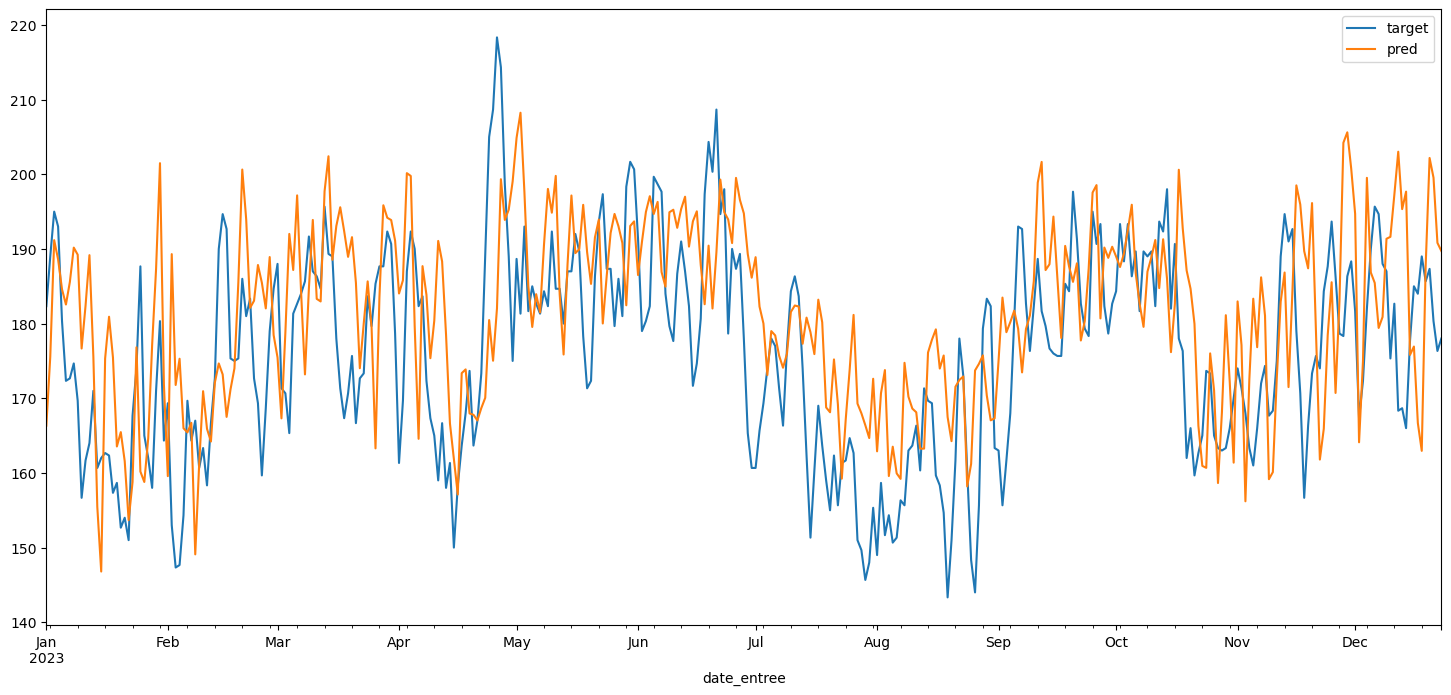

In [19]:
dg['seasonal'] = result.seasonal
dg['pred'] = dg.apply(lambda x: x['pred'] + x['seasonal'], axis=1)
dg.plot(y=['target', 'pred'])
print(f"MAE: {mean_absolute_error(dg['target'], dg['pred']):.2f}")


In [20]:
dg0 = df0.copy()
dg0['resid'] = result.resid
dg0.drop('target', axis=1, inplace=True)
dg0.rename({'resid': 'target'}, axis=1, inplace=True)
dg0.dropna(inplace=True)
dg0['target'] = dg0['target'].apply(lambda x: 1 if x > 0 else 0)

In [21]:
# Paramètres adaptés pour la classification binaire
params = {
    'eta': 0.05, 
    'objective': 'binary:logistic',  # Classification binaire
    'eval_metric': ['logloss', 'error'],  # Log loss et taux d'erreur
    'subsample': 0.7, 
    'colsample_bytree': 0.7,
    'nthread': -1
}

X_final = dg0.loc[dg0.index.year == 2023].drop('target', axis=1)
y_final = dg0.loc[dg0.index.year == 2023]['target']

train_val_test = dg0.loc[dg0.index.year < 2023]
X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                    train_val_test['target'], 
                                                    test_size=0.2, shuffle=False)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_final, label=y_final)
evals = [(dtrain, 'train'), (dvalid, 'eval')]


# Entraînement avec early stopping
bst = xgb.train(
    params,
    dtrain,  # DMatrix contenant les données d'entraînement
    num_boost_round=100000,
    evals=evals,  # Liste des ensembles d'évaluation
    early_stopping_rounds=15,
    verbose_eval=True
)

# Prédiction des probabilités sur un ensemble de test
proba_preds = bst.predict(dtest)

# Conversion des probabilités en classes binaires (0 ou 1)
class_preds = (proba_preds >= 0.5).astype(int)

scale = result.resid.dropna().abs().mean()

class_preds = [(2*p-1)*scale for p in class_preds]

# Affichage des prédictions de classes
print(class_preds)

[0]	train-logloss:0.68150	train-error:0.37280	eval-logloss:0.69117	eval-error:0.44649
[1]	train-logloss:0.67170	train-error:0.27660	eval-logloss:0.69220	eval-error:0.47232
[2]	train-logloss:0.65992	train-error:0.24699	eval-logloss:0.69537	eval-error:0.51661
[3]	train-logloss:0.64914	train-error:0.18409	eval-logloss:0.69507	eval-error:0.50554
[4]	train-logloss:0.64074	train-error:0.18316	eval-logloss:0.69657	eval-error:0.48339
[5]	train-logloss:0.63393	train-error:0.17299	eval-logloss:0.69624	eval-error:0.51661
[6]	train-logloss:0.62553	train-error:0.14986	eval-logloss:0.69688	eval-error:0.48339
[7]	train-logloss:0.61846	train-error:0.13691	eval-logloss:0.69407	eval-error:0.49077
[8]	train-logloss:0.60764	train-error:0.11933	eval-logloss:0.69621	eval-error:0.49077
[9]	train-logloss:0.59991	train-error:0.11008	eval-logloss:0.69699	eval-error:0.48708
[10]	train-logloss:0.59294	train-error:0.10916	eval-logloss:0.69666	eval-error:0.50185
[11]	train-logloss:0.58323	train-error:0.08788	eval-l

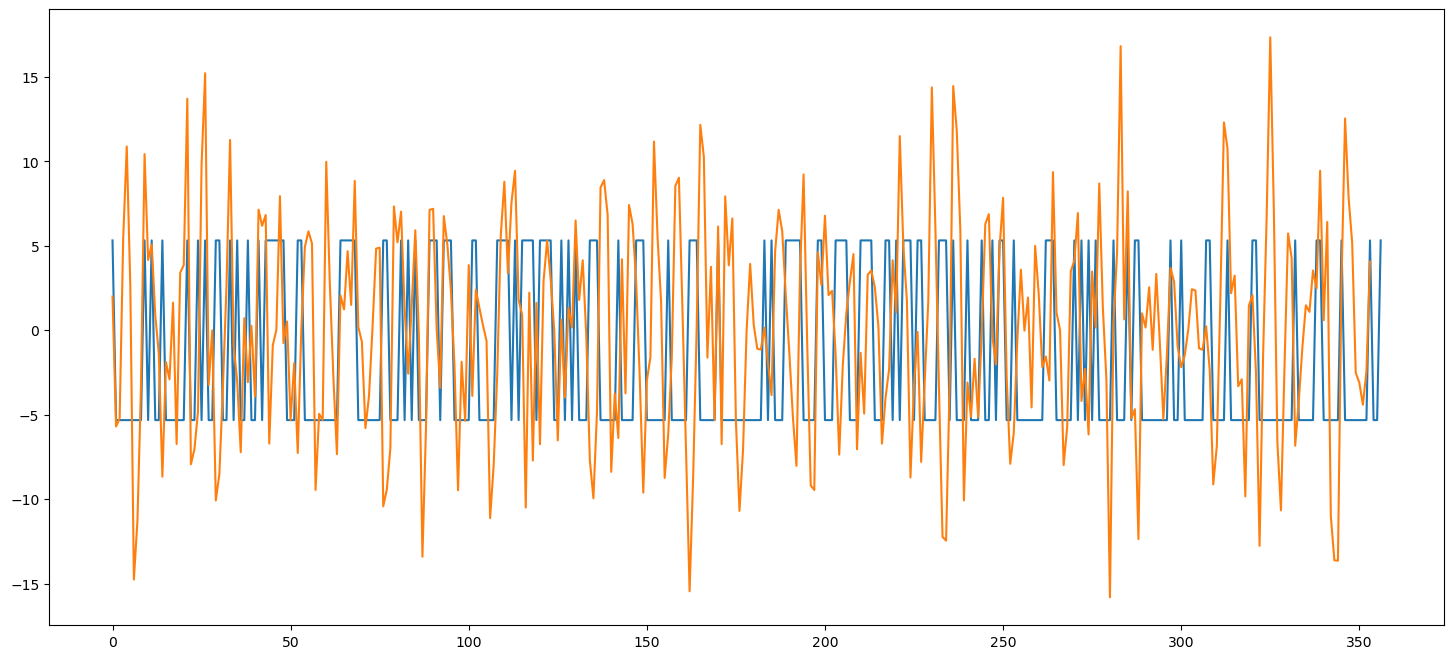

In [22]:
plt.plot(range(len(class_preds)), class_preds)
plt.plot(range(len(class_preds)), result.resid[-len(class_preds):])
plt.show()

MAE: 10.95


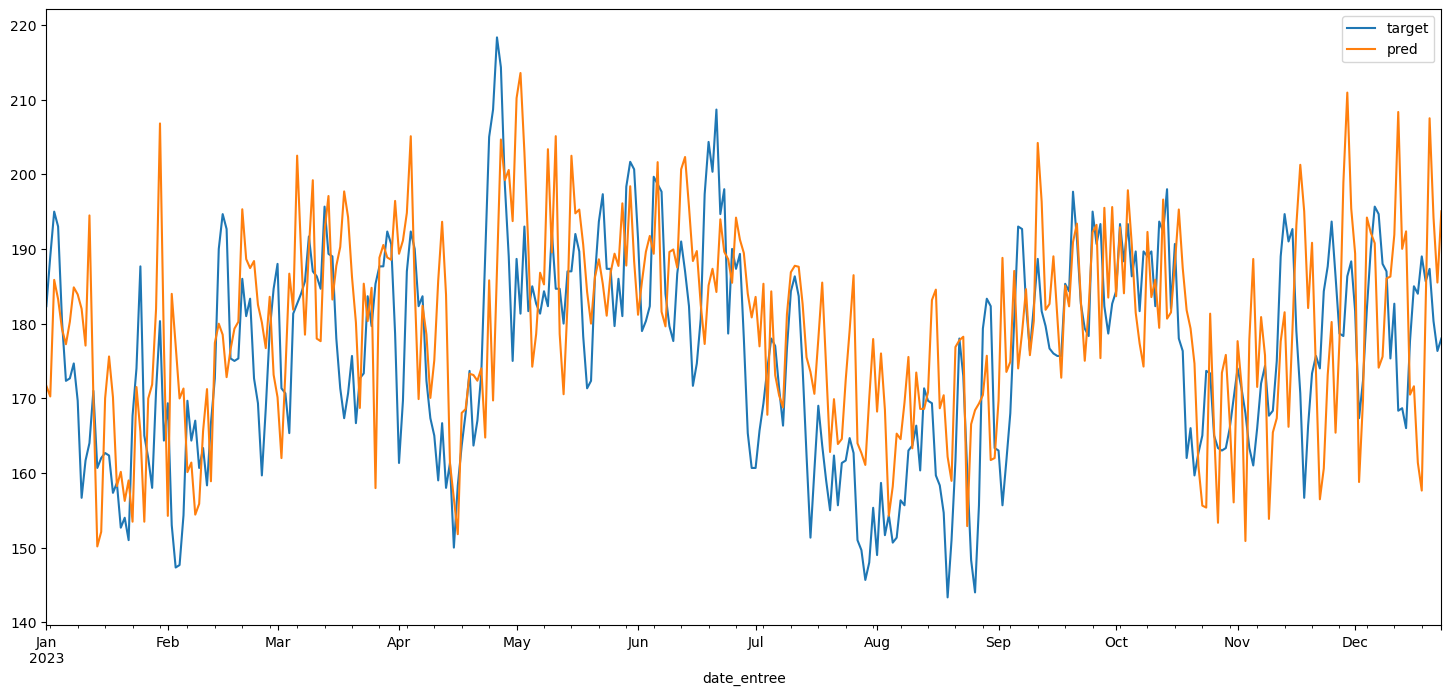

In [23]:
dg['residue'] = class_preds
dg['pred'] = dg.apply(lambda x: x['pred'] + x['residue'], axis=1)
dg.plot(y=['target', 'pred'])
print(f"MAE: {mean_absolute_error(dg['target'], dg['pred']):.2f}")


In [26]:
# Un exemple pour déterminer l'importance des variables après un pré-apprentissage XGBoost
importance_gain = bst.get_score(importance_type='gain')
importance_cover = bst.get_score(importance_type='cover')
importance_weight = bst.get_score(importance_type='weight')

df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df['gain_norm'] = df['gain'] / df['gain'].sum()
df['cover_norm'] = df['cover'] / df['cover'].sum()
df['weight_norm'] = df['weight'] / df['weight'].sum()

w_gain = 0.5
w_cover = 0.3
w_weight = 0.2

df['importance'] = (df['gain_norm'] * w_gain) + (df['cover_norm'] * w_cover) + (df['weight_norm'] * w_weight)

df.sort_values(by='importance', ascending=False, inplace=True)
df['rank'] = df['importance'].rank(ascending=False)

df.reset_index(inplace=True)
df.rename(columns={'index': 'feature'}, inplace=True)
print(df[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']])


                  feature       gain       cover  weight  importance   rank
0               dayofweek  14.086691  183.958206     5.0    0.012861    1.0
1       trend_hopital_J-5  13.299729   87.881310     7.0    0.010080    2.0
2       trend_hopital_J-6  14.853248  150.015381     1.0    0.010054    3.0
3       arrivees_urgences  10.756468  141.324341     4.0    0.009933    4.0
4       trend_hopital_J-7  10.254529  117.447426     6.0    0.009832    5.0
..                    ...        ...         ...     ...         ...    ...
249      air_PM25_FR26005   1.879937    7.221164     1.0    0.001242  250.0
250     inc_diarrhee_J-13   1.973167    5.072246     1.0    0.001191  251.0
251  air_PM10_FR26014_std   1.526453    5.747398     1.0    0.001089  252.0
252       inc_grippe_J-10   1.248711    5.203798     1.0    0.000991  253.0
253    trend_maladie_mean   0.180713    2.465013     1.0    0.000590  254.0

[254 rows x 6 columns]
